In [ ]:
import torch

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [ ]:
# build vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# shuffle up the words
random.seed(42)
random.shuffle(words)

In [ ]:
# build dataset
block_size = 8    # context length: how many characters do we take to predict the next character

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# Layers
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# --------------------------------------------------------- #
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (training with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x) :
    # calculate forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # scale and shift

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -------------------------------------------------------- #

class Tanh:
  def __call__(self, x) :
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -------------------------------------------------------- #
class Embedding:
  def __init__(self, num_emb, emb_dim):
    self.weight = torch.randn((num_emb, emb_dim))

  def __call__(self, IX) :
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ------------------------------------------------------- #
class FlattenConsecutive:

  def __init__(self, n): # n : no.of elements that we can to be concatenated in the last dim of output
        self.n = n

  def __call__(self, x):
    B, T, C = x.shape     # B:Batch, T:block_size, C:n_emb
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(dim=1)

    self.out = x
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------- #
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
torch.manual_seed(42);

In [ ]:
n_emb = 32  # the dimensionality of character embedding vector
n_hidden = 134 # the number of neurons in hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters
for p in parameters:
  p.requires_grad = True


85713


In [ ]:
model.layers[3].running_mean.shape

torch.Size([134])

In [ ]:
# optimization
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):

  # mini batch construct
  ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]   # plucks out random batch_size=32 rows from training set (182456, 3)

  # forward pass
  # emb = C[Xb]   # enmbed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1   # step learning rate decay
  if i > 80000 and i < 140000:
    lr /= 10
  elif i >140000:
    lr /= 10

  # update parameters using SGD
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())




      0/ 200000: 3.3249
  10000/ 200000: 1.8957
  20000/ 200000: 2.1251
  30000/ 200000: 1.7794
  40000/ 200000: 1.8932
  50000/ 200000: 1.7849
  60000/ 200000: 1.9770
  70000/ 200000: 1.8170
  80000/ 200000: 1.7534
  90000/ 200000: 1.7487
 100000/ 200000: 1.7264
 110000/ 200000: 1.5592
 120000/ 200000: 1.6416
 130000/ 200000: 1.6715
 140000/ 200000: 1.7937
 150000/ 200000: 1.8006
 160000/ 200000: 1.6650
 170000/ 200000: 1.8418
 180000/ 200000: 1.5256
 190000/ 200000: 1.9216


In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (64, 8, 32)
FlattenConsecutive : (64, 4, 64)
Linear : (64, 4, 134)
BatchNorm1d : (64, 4, 134)
Tanh : (64, 4, 134)
FlattenConsecutive : (64, 2, 268)
Linear : (64, 2, 134)
BatchNorm1d : (64, 2, 134)
Tanh : (64, 2, 134)
FlattenConsecutive : (64, 268)
Linear : (64, 134)
BatchNorm1d : (64, 134)
Tanh : (64, 134)
Linear : (64, 27)


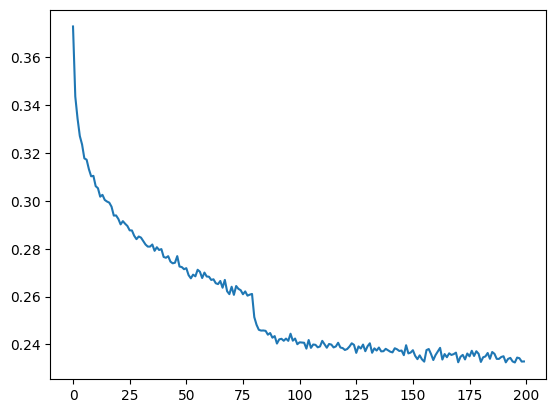

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))


In [ ]:
# put all layers into eval mode
for layer in model.layers:
  layer.training = False

In [ ]:
# eval the loss
@torch.no_grad() # this decorator disables gradiant tracking inside pytorch
def split_loss(split):
  x,y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test' : (Xte, Yte),
  } [split]
  # emb = C[x]  # (N, block_size, n_emb)
  # x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_emb)
  # for layer in layers:
  # x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.6906023025512695
val 2.0237276554107666


### performance log:
* original (3 character context + 200 hidden neurons, 12k params): train 2.058, val 2.106
* conext: 3->8 (22k parameters): train 1.916, val 2.034
* flat -> hierarchical (22k parameters): train 1.943, val 2.0329
* fix bug in batchnorm: train 1.9108, val 2.0204
* scale up the network: (8 character context + 128 hidden neurons, 24 embeddings) 76k params: train 1.768, val 1.993


In [ ]:
# sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size # initialize with '...'
  while True:
    # forward pass
    # emb = C[torch.tensor([context])]  # (1, block_size, n_emb)
    # x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # for layer in layers:
    #  x = layer(x)
    # logits = x
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

amiri.
matkayus.
natalie.
ezabella.
abdulee.
konnie.
ovi.
aula.
ava.
nadency.
betsier.
jerriah.
devina.
limonie.
elieanna.
maximo.
macari.
daelynn.
antwari.
braycey.
